In [173]:
import tensorflow as tf
import logging
import numpy as np
import matplotlib.pyplot as plt

import math

from utils import data_provider
from notebook_utils import plot
plot.setup(plt)

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO, stream=sys.stdout)

INFO:notebook_utils.plot:Setup plot parameters


# Data Preparation

In [176]:
X_train, Y_train = data_provider.get_mnist('train', dir_path='../data/mnist')
X_test, Y_test = data_provider.get_mnist('test', dir_path='../data/mnist')

INFO:utils.data_provider:Load MNIST : train
INFO:utils.data_provider:Load MNIST : test


In [177]:
X_train_2d = np.copy(X_train.reshape((-1,28,28)))
X_test_2d = np.copy(X_test.reshape((-1,28,28)))

INFO:notebook_utils.plot:save fig to ../figures/nb_figures/mnist-label5-with-cols.png


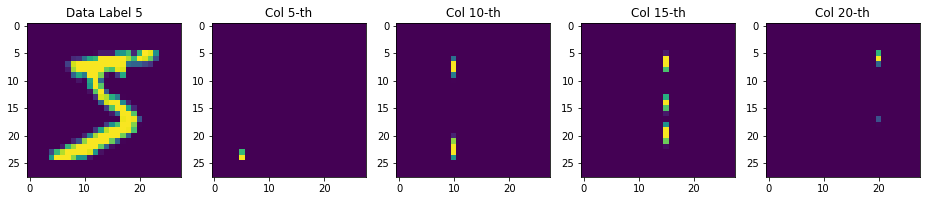

In [91]:
def plot_mnist_with_columns(data_idx, col_indices):
    plt.figure(figsize=(16,3))

    plt.subplot(1,5,1)

    plt.imshow(X_train[data_idx,:].reshape((28,28)))
    plt.title('Data Label %d' % int(np.sum(np.arange(10) * Y_train[data_idx,:])))

    count = 2
    for col_idx in col_indices:
        plt.subplot(1,5,count)
        img_zero = np.zeros((28,28))
        img_zero[:, col_idx] = X_train_2d[data_idx, :, col_idx]
        plt.title('Col %d-th' % col_idx)
        plt.imshow(img_zero, vmin=0, vmax=255)
        count = count + 1
plot_mnist_with_columns(data_idx = 0, col_indices = [5, 10,15,20])
plt.show_and_save(title='mnist-label5-with-cols.png');

# Training

In [187]:
NETWORK_PARAMS = {
    'batch_size': 100,
    'hidden_units': 5,
    'learning_rate': 0.2,
    'output_units': 10,
    'input_dims' : 28,
    'train_epochs': 10
}

In [168]:
def batch_data(x, y, n=1):
    l = len(x)
    for ndx in range(0, l, n):
        yield (x[ndx:min(ndx + n, l)],  y[ndx:min(ndx + n, l)])

In [190]:
# Create some variables.
recurrent_inputs = tf.Variable(tf.zeros((NETWORK_PARAMS['batch_size'],NETWORK_PARAMS['output_units'])))
input_weights = tf.Variable(
    tf.truncated_normal(
        (
         NETWORK_PARAMS['input_dims'] + NETWORK_PARAMS['output_units'],
         NETWORK_PARAMS['hidden_units']
        ),
        stddev=0.1
    ),
    name="input_weights"
)

output_weights = tf.Variable(
    tf.truncated_normal(
        (NETWORK_PARAMS['hidden_units'], NETWORK_PARAMS['output_units']),
        stddev=0.1
    ),
    name="output_weights"
)

x_input = tf.placeholder(tf.float32, shape=(NETWORK_PARAMS['batch_size'], NETWORK_PARAMS['input_dims'], NETWORK_PARAMS['input_dims']))
y_ = tf.placeholder(tf.float32, [NETWORK_PARAMS['batch_size'], 10])

rr = recurrent_inputs
for i in range(NETWORK_PARAMS['input_dims']):
    xr = tf.concat([ x_input[:,i], rr], axis=1)
    ha = tf.nn.relu(tf.matmul(xr, input_weights))
    ot = tf.nn.relu(tf.matmul(ha, output_weights))
    # todo recurrent weight
    rr = ot

y = tf.nn.softmax(ot)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

init_op = tf.global_variables_initializer()

# saver = tf.train.Saver()

# Later, launch the model, initialize the variables, do some work, save the
# variables to disk.
with tf.Session() as sess:
    sess.run(init_op)

    iw, ri = sess.run([input_weights, recurrent_inputs])
    total_training_size = X_train_2d.shape[0]
    
    for i in range(NETWORK_PARAMS['train_epochs']):
        logging.info('epoch %d' % i)
        for xf, yf in batch_data(X_train_2d, Y_train, n=NETWORK_PARAMS['batch_size']):
            train_step.run(feed_dict={x_input: xf, y_: yf})

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))

    sum_acc = 0.0
    for xf, yf in batch_data(X_test_2d, Y_test, n=NETWORK_PARAMS['batch_size']):
        sum_acc = sum_acc + accuracy.eval(feed_dict={x_input: xf, y_: yf})

    print('Accuracy %f%%' % (sum_acc*100/len(X_test_2d)))
#   save_path = saver.save(sess, "/tmp/model.ckpt")
#   print("Model saved in file: %s" % save_path)

INFO:root:epoch 0
INFO:root:epoch 1
INFO:root:epoch 2
INFO:root:epoch 3
INFO:root:epoch 4
INFO:root:epoch 5
INFO:root:epoch 6
INFO:root:epoch 7
INFO:root:epoch 8
INFO:root:epoch 9


Accuracy 22.420000%


## Define network params

## Define  network structure

In [152]:
math.ceil(7/10.0)

1

In [170]:
for xf,yf in batch_data(X_train_2d, Y_train, n=NETWORK_PARAMS['batch_size']):
    print(yf.shape)
    print(count)

(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100, 10)
0
(100